In [137]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numba
from mpl_toolkits.mplot3d import Axes3D

In [138]:
L = 250
N = 100
x = np.arange(-int(L/2), int(L/2), 1)
y = np.arange(-int(L/2), int(L/2), 1)
spx, spy = np.meshgrid(x, y)
delta_theta = np.zeros(N)
v = 0.3

##x represents coordinates, v has the components of the velocity (probably superfluous, psi is the orientation, omega is the 
##angular velocity and r is the radius.
particles_x = np.zeros([N, 2])
particles_v = np.zeros([N, 2])
particles_psi = np.zeros(N)
particles_omega = np.zeros(N)
particles_r = np.zeros(N)

In [139]:
for i in range (int(np.sqrt(N))):
    particles_x[10*i:10*(i+1), 0] = np.arange(0, 10)
    particles_x[10*i:10*(i+1), 1] = i
    
particles_r[:] = np.random.normal(1, 0.1, N)
particles_psi = particles_psi - delta_theta
particles_v[:, 0] = v*np.cos(particles_psi)
particles_v[:, 0] = v*np.sin(particles_psi)

In [148]:
def update(N, particles_x, particles_r, particles_psi):
    F_x = np.zeros(N)
    F_y = np.zeros(N)
    
    dx = np.zeros(N)
    dy = np.zeros(N)
    
    v = 0.3
    
    theta_out = np.zeros(N)
    theta_in = np.zeros(N)
    d_theta = np.zeros(N)
    
    particles_omega = (v)/particles_r
    
    psi_diff = np.zeros([N, N])
    psi_diff = particles_psi[None, :] - particles_psi[:, None]
    
    ##distances and angles calculations
    d = np.linalg.norm(particles_x[None, :, :] - particles_x[:, None, :], axis = 2)
    
    select_matrix = np.copy(d)
    select_matrix[select_matrix > 2.7] = 0
    select_matrix[select_matrix > 0] = 1 ##the selection matrix is used to only take into account the neighbours with d < 2.7
    
    particles_dist = particles_x[None, :, :] - particles_x[:, None, :]
    
    for i in range (N):
        particles_dist[i, i, :] = 100
    
    print (particles_dist)
    ##normally, atan return a value between -pi/2 and pi/2. atan2 returns a value between pi and -pi.
    
    angles = select_matrix*np.arctan2(particles_dist[:, :, 1], particles_dist[:, :, 0])
    
    psi_diff = psi_diff * select_matrix
    
    ##OPTIMIZATION NEEDED
    for i in range (0, N):
        for j in range (0, N):
            d[i, j] -= particles_r[i] + particles_r[j]
    d[d<0] = 0
    
    ##distances along different axes
    dx = d*np.cos(angles[:])
    dy = d*np.sin(angles[:])
    
    ##NEEDS OPTIMIZATION
    for i in range (N):
        M = max(angles[i, :])
        m = min(angles[i, :])
        if M > 0 and m < 0:
            if M - m < np.pi:
                theta_in[i] = (M-m)/2
                theta_out[:] = 2*np.pi - 2*theta_in
                d_theta = particles_psi - theta_in
        elif (M > 0 and m > 0) or (M < 0 and m < 0):
            theta_in[i] = (M-m)/2
            theta_out[:] = 2*np.pi - 2*theta_in
            d_theta = particles_psi - theta_in
    
    ##force calculations
    F_x[:] = v*np.cos(particles_psi[:]) + (theta_out[:] - np.pi)*theta_out[:]*np.piecewise(theta_out[:] -np.pi, [theta_out[:] -np.pi > 0], [0, 1])*np.cos(particles_psi[:]) - 1*np.sum(dx, axis = 1)[:]
    F_y[:] = v*np.sin(particles_psi[:]) + (theta_out[:] - np.pi)*theta_out[:]*np.piecewise(theta_out[:] -np.pi, [theta_out[:] -np.pi > 0], [0, 1])*np.sin(particles_psi[:]) - 1*np.sum(dy, axis = 1)[:]
    
    T = particles_omega[:]*np.piecewise(theta_out[:] -np.pi, [theta_out[:] -np.pi > 0], [0, 1]) + 1*np.random.uniform(-1,1, N) + 1*np.sum(psi_diff, axis = 1)[:]
    
    particles_x[:, 0] = np.mod(particles_x[:, 0] + F_x[:], L)
    particles_x[:, 1] = np.mod(particles_x[:, 1] + F_y[:], L)
    particles_omega[:] = - (particles_psi[:] - T*1)
    particles_psi[:] = particles_psi[:] + particles_omega[:]
    
    return particles_x, particles_psi

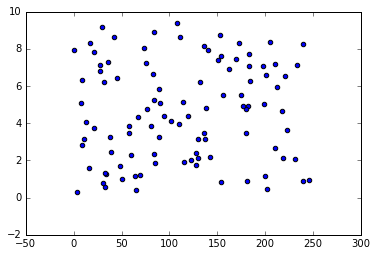

In [151]:
plt.scatter(particles_x[:, 0], particles_x[:, 1])
plt.show()

In [150]:
particles_x, particles_psi = update(N, particles_x, particles_r, particles_psi)

[[[  1.00000000e+02   1.00000000e+02]
  [ -4.49564259e+05   1.83981609e-01]
  [ -6.42116474e+05   5.09937370e-01]
  ..., 
  [ -6.84363498e+05   8.85179009e+00]
  [ -3.55727426e+05   7.32652732e+00]
  [  2.25669560e+05   7.88553488e+00]]

 [[  4.49564259e+05  -1.83981609e-01]
  [  1.00000000e+02   1.00000000e+02]
  [ -1.92552215e+05   3.25955762e-01]
  ..., 
  [ -2.34799239e+05   8.66780849e+00]
  [  9.38368327e+04   7.14254571e+00]
  [  6.75233818e+05   7.70155328e+00]]

 [[  6.42116474e+05  -5.09937370e-01]
  [  1.92552215e+05  -3.25955762e-01]
  [  1.00000000e+02   1.00000000e+02]
  ..., 
  [ -4.22470239e+04   8.34185272e+00]
  [  2.86389048e+05   6.81658995e+00]
  [  8.67786034e+05   7.37559751e+00]]

 ..., 
 [[  6.84363498e+05  -8.85179009e+00]
  [  2.34799239e+05  -8.66780849e+00]
  [  4.22470239e+04  -8.34185272e+00]
  ..., 
  [  1.00000000e+02   1.00000000e+02]
  [  3.28636072e+05  -1.52526277e+00]
  [  9.10033058e+05  -9.66255211e-01]]

 [[  3.55727426e+05  -7.32652732e+00]
  [